In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
from nengo import spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_alt_vocab

In [2]:
t_present = 0.3
t_pause = 0.1
dimensions = 32
n_neurons = 25
dt = 0.001
seed = 8

In [3]:
t_pres = int(t_present / dt)
t_paus = int(t_pause / dt)
slc_tm = (t_paus+t_pres)

In [4]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(5, 5, dimensions, seed, norm=True)

In [5]:
fan_vecs = np.concatenate((fan1_vecs, fan2_vecs))
simi = np.dot(fan_vecs, fan_vecs.T)
np.fill_diagonal(simi, 0.)
intercept = np.ceil(np.max(simi)*100)/100
print(intercept)

0.6


In [6]:
foil_vecs = np.concatenate((foil1_vecs, foil2_vecs))

In [7]:
all_labels = []
for i1, i2 in fan1+fan2:
    all_labels.append(f"{i1}+{i2}")
print(all_labels)

['F1_0+F1_1', 'F1_2+F1_3', 'F1_4+F1_5', 'F1_6+F1_7', 'F1_8+F1_9', 'F2_1+F2_2', 'F2_4+F2_0', 'F2_4+F2_1', 'F2_3+F2_0', 'F2_2+F2_3']


# Assoc Mem into Ensemble

In [123]:
res_neurons = 500

data_feed = BasicVecFeed(fan_vecs, fan_vecs, t_present, dimensions, len(fan_vecs), t_pause)

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    # Note: if the threshold is set too high, it won't respond even close to the MEG
    # because it will then ignore values that would otherwise be considered similar
    # so set it as low as possible to see MEG-like effects
    mem = nengo.networks.AssociativeMemory(fan_vecs, n_neurons=n_neurons, threshold=0.71)
    res_ens = nengo.Ensemble(res_neurons, dimensions)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(mem.output, res_ens)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(res_ens.neurons, synapse=None)

In [124]:
with nengo.Simulator(model) as sim:
    sim.run(len(fan_vecs)*(t_present+t_pause) + t_pause)

/home/saubin/git/nengo/nengo/cache.py:501: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn("Decoder cache could not acquire lock and was "


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:05.                                                 


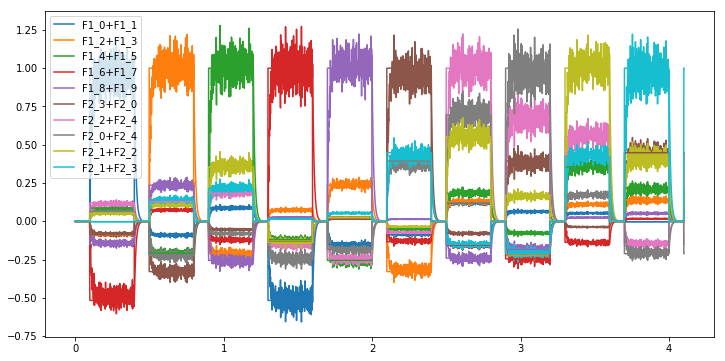

In [125]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], fan_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], fan_vecs))

plt.legend(all_labels)

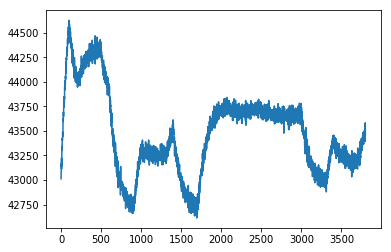

In [126]:
plt.plot(meg_from_spikes(sim.data[p_spikes])[300:])

The response is basically random, surprising nobody, since the encoder distribution is random.

# Specially Tuned Encoders

This is only feasible if the vectors aren't actually overlapping.

In [53]:
from sklearn.decomposition import PCA

In [109]:
pca = PCA(n_components=3)

all_vecs = np.concatenate((fan_vecs, foil_vecs))

f_vecs_dict = {"fan1": fan1_vecs, "fan2": fan2_vecs, "foil1": foil1_vecs, "foil2": foil2_vecs}
p_vecs_dict = dict()

pca.fit(all_vecs)

for nm, vecs in f_vecs_dict.items():
    p_vecs_dict[nm] = pca.transform(vecs)

p_vecs = np.concatenate(list(p_vecs_dict.values()), axis=0)
print(p_vecs.shape)

(20, 3)


In [110]:
max_vec = np.max(p_vecs, axis=0)
min_vec = np.min(p_vecs, axis=0)
print(max_vec.shape)

(3,)


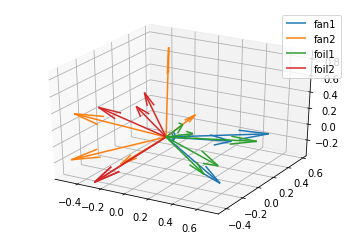

In [113]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s_i, (nm, vecs) in enumerate(p_vecs_dict.items()):
    soa = np.concatenate((np.zeros((vecs.shape[0], 3)), vecs), axis=1)
    X, Y, Z, U, V, W = zip(*soa)
    ax.quiver(X, Y, Z, U, V, W, color="C%s" % s_i, label=nm)

ax.set_xlim([min_vec[0], max_vec[0]])
ax.set_ylim([min_vec[1], max_vec[1]])
ax.set_zlim([min_vec[2], max_vec[2]])
plt.legend()

In [8]:
mean_fan1 = np.mean(fan1_vecs, axis=0)
print(mean_fan1.shape)

mean_fan2 = np.mean(fan2_vecs, axis=0)
print(mean_fan2.shape)

(32,)
(32,)


In [13]:
fan1_space = []
for vec in fan1_vecs:
    fan1_space.append(np.dot(vec, mean_fan1))
print(np.mean(fan1_space))

0.154924601272


In [14]:
fan2_space = []
for vec in fan2_vecs:
    fan2_space.append(np.dot(vec, mean_fan2))
print(np.mean(fan2_space))

0.333860920479
